This line is for just importing packages. I just copied it from one of the notebooks (We actually dont need all the imported functions). 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["OMP_NUM_THREADS"] = "1"

import numpy as np
import dask.array as da
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
# from dask_ml.decomposition import PCA
from dask_ml.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from pymks import (
    generate_multiphase,
    generate_delta,
    plot_microstructures,
    PrimitiveTransformer,
    FlattenTransformer,
    solve_fe,
    TwoPointCorrelation,
    FlattenTransformer,
    LocalizationRegressor
)

So you have your data. I am creating some random microstructures to show the procedure. `x_data` here will be your data (1x128x128). You don't need the code below.

In [2]:
da.random.seed(10)
np.random.seed(10)

x_data = da.concatenate([
    generate_multiphase(shape=(1, 128, 128), grain_size=(25, 25), volume_fraction=(0.5, 0.5)),
    
]).persist()

To visualize the data

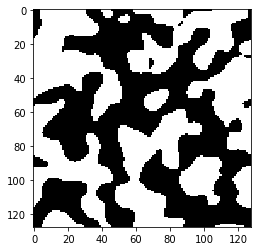

In [3]:
plt.imshow(x_data[0,:,:], cmap='gray')

I created the (1 x 128 x 128 x 1) 

In [4]:
x_data=x_data.reshape((1,128,128,1))
x_data.shape

(1, 128, 128, 1)

# You can start from here

This is how you can calculate the Two point stats. Here `(0,0)` means autocorrelation for the first state ( currentlty I have 1 x 128 x 128 x 1 ,and I have only one phase but your case you have 5 of them as your array is 1 x 128 x 128 x 5) Lets say you want to have 1 autocorrealtion of first phase and 2 crosscorrelations with next two phase ( - x - x- x 1 and - x - x- x 2) , then use ` correlations=[(0,0) , (0,1),(0,2)]`

In [5]:
TwoPt=TwoPointCorrelation(periodic_boundary=True, cutoff=25,correlations=[(0,0)])
AutoCorrelation=TwoPt.transform(x_data.compute())

If you want to visualize it, we have a function in pymks but you can just use matplotlib as well.

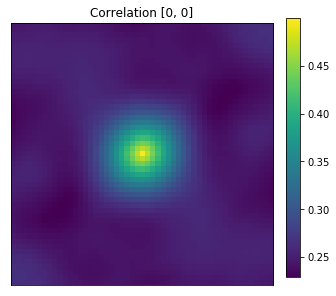

In [6]:
plot_microstructures(
    AutoCorrelation[0, :, :, 0],
    titles=['Correlation [0, 0]']
)

This was for single microstructure. Lets do it for multiple microstructures. I am again generating my own data you don't need the code below


In [7]:
da.random.seed(10)
np.random.seed(10)

nx_data = da.concatenate([
    generate_multiphase(shape=(20, 128, 128), grain_size=(25, 25), volume_fraction=(0.5, 0.5)),
    
]).persist()
nx_data=PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0).transform(nx_data).compute()



I created my microstructures and now I have (20 x 128 x 128 x 2). That means I have 20 microstructures ( all of them are 129 x 128 ) and I have 2 phases for each microstructure.

In [8]:
nx_data.shape

(20, 128, 128, 2)

I will use the same function but this time I will calculate `(0,0) and (0,1)`.

In [9]:
TwoPt=TwoPointCorrelation(periodic_boundary=True, cutoff=25,correlations=[(0,0),(0,1)])
AutoCorrelation=TwoPt.transform(nx_data).compute()

As you can see below I have correlations for all of my microstructures.- x - x - x 0 is (0,0) , - x - x - x 1 is (0,1)

In [10]:
AutoCorrelation.shape

(20, 51, 51, 2)

Then we flatten this data to use PCA

In [11]:
flatten=FlattenTransformer().transform(AutoCorrelation)

As you can see all the correlation information was flatten. Each row contains information for a single microstructure

In [12]:
flatten.shape

(20, 5202)

Then we do the PCA.

In [13]:
PC_scores=PCA(svd_solver='full', n_components=5).fit(flatten).transform(flatten)

Now we calculated the PC scores for each microstructure

In [14]:
PC_scores

array([[-0.06434185, -0.14664027,  0.22749412,  0.04047964,  0.0784144 ],
       [ 0.73447299, -0.23899686,  0.72259265, -0.40436187,  0.05611539],
       [-0.11845725,  0.33319871,  0.14709364, -0.10812686, -0.09647473],
       [-0.53464379, -0.10831666,  0.93845668,  0.1526426 ,  0.3080698 ],
       [-0.96450664, -0.50638643, -0.32484683,  0.69522489, -0.01541403],
       [-0.22341868, -0.6924235 , -0.25166085, -0.58555094, -0.17430349],
       [-0.21256212,  0.0832417 ,  0.17696143, -0.08414717,  0.05320936],
       [ 0.3696354 ,  0.02500941, -0.09125428, -0.29893808,  0.24534629],
       [-0.36691261,  0.65731715, -0.01749438, -0.04046878, -0.46703295],
       [-0.02541612,  0.33871871,  0.13449415, -0.05805418,  0.48224289],
       [ 0.01577694,  0.40286758, -0.6549982 ,  0.02420367,  0.46493001],
       [ 0.50081393, -0.1184354 , -0.05325768,  0.46147215, -0.22634153],
       [-0.28806578, -0.59842922, -0.16191097,  0.26947099,  0.17907329],
       [ 0.01932358,  0.14838255, -0.3

Finally lets visualize 

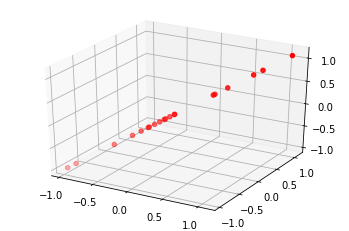

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(PC_scores[:,0], PC_scores[:,0], PC_scores[:,0], c='r', marker='o')

In [16]:
PC_scores[:,:3].shape

(20, 3)